In [1]:
# import necessary packages
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax



from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle
import gzip

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('../data/train.csv')
store_df=pd.read_csv('../data/store.csv',low_memory=False)
test_df=pd.read_csv('../data/test.csv')

In [3]:
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)
#merge the train data with store data
train_store=train_df.merge(store_df,on='Store')
train_store.fillna(0, inplace=True)
test_store=test_df.merge(store_df,on='Store')
test_store.fillna(0,inplace=True)

# Machine learning

#### Preprocessing

In [4]:
def preprocess_data(train_store, test_store):
    
    # preprocessing
    global train_features, test_features, train_target, categorical, numerical
    # train and target features
    train_features = train_store.drop(['Sales', 'Customers'], axis = 1) #drop the target feature + customers ( will not be used for prediction)
    train_target  = train_store[['Sales']]
    test_features = test_store.drop(['Id'], axis = 1) #drop id, it's required only during submission
    
    #feature generation + transformations
    train_features['Date'] = pd.to_datetime(train_features.Date)
    train_features['Month'] = train_features.Date.dt.month.to_list()
    train_features['Year'] = train_features.Date.dt.year.to_list()
    train_features['Day'] = train_features.Date.dt.day.to_list()
    train_features['WeekOfYear'] = train_features.Date.dt.weekofyear.to_list()
    train_features['DayOfWeek'] = train_features.Date.dt.dayofweek.to_list()
    train_features['weekday'] = 1        # Initialize the column with default value of 1
    train_features.loc[train_features['DayOfWeek'] == 5, 'weekday'] = 0
    train_features.loc[train_features['DayOfWeek'] == 6, 'weekday'] = 0
    train_features = train_features.drop(['Store'], axis = 1)
  

    test_features['Date'] = pd.to_datetime(test_features.Date)
    test_features['Month'] = test_features.Date.dt.month.to_list()
    test_features['Year'] = test_features.Date.dt.year.to_list()
    test_features['Day'] = test_features.Date.dt.day.to_list()
    test_features['WeekOfYear'] = test_features.Date.dt.weekofyear.to_list()
    test_features['DayOfWeek'] = test_features.Date.dt.dayofweek.to_list()
    test_features['weekday'] = 1        # Initialize the column with default value of 1
    test_features.loc[test_features['DayOfWeek'] == 5, 'weekday'] = 0
    test_features.loc[test_features['DayOfWeek'] == 6, 'weekday'] = 0
    test_features = test_features.drop(['Store'], axis = 1)

    # numerical and categorical columns (train set)
    categorical = []
    numerical = []
    timestamp = []
    
    
    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features]) #merge the features columns for uniform preprocessing

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64') 
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"

     # numeric
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean()))) 
    features.PromoInterval = features.PromoInterval.fillna(features.PromoInterval.mode()[0])
    features.Open = features.Open.fillna(features.Open.mode()[0])        
    features = pd.get_dummies(features, columns=['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday'], drop_first=True)        
    scaler = RobustScaler()

    features[numerical] = scaler.fit_transform(features[numerical].values)


    return features

In [5]:
features = preprocess_data(train_store, test_store)
features = features.drop(['Date'], axis = 1)
# features.Open.unique()
features.head()

,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.25,0.0,1.0,1.0,-0.171266,0.555556,0.000995,-1.0,-0.045455,-0.998509,...,1,0,0,0,0,0,0,0,0,0
1,0.00,0.0,1.0,1.0,-0.171266,0.555556,0.000995,-1.0,-0.045455,-0.998509,...,1,0,0,0,0,0,0,0,0,0
2,-0.25,0.0,1.0,1.0,-0.171266,0.555556,0.000995,-1.0,-0.045455,-0.998509,...,1,0,0,0,0,0,0,0,0,0
3,-0.50,0.0,1.0,1.0,-0.171266,0.555556,0.000995,-1.0,-0.045455,-0.998509,...,1,0,0,0,0,0,0,0,0,0
4,-0.75,0.0,1.0,1.0,-0.171266,0.555556,0.000995,-1.0,-0.045455,-0.998509,...,1,0,0,0,0,0,0,0,0,0


In [6]:
# reconstruct train and test sets
def reconstruct_sets(features):
    global x_train, x_val, y_train, y_val
    x_train = features.iloc[:len(train_features), :]
    x_test = features.iloc[len(train_features):, :]
    y_train = train_target
    
     # updated train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .20, random_state = 0)
    return x_train, x_val, y_train, y_val,x_test


In [7]:
x_train, x_val, y_train, y_val, x_test = reconstruct_sets(features)
pd.concat([x_train,y_train]).to_csv('../data/final_train.csv')
x_test.to_csv('../data/final_test.csv')
#len(train_features)

In [8]:
# log transformation on target variable
y_train = np.log1p(y_train['Sales'])
y_val = np.log1p(y_val['Sales'])

#### model building and prediction

In [10]:
# RandiomForestRegressor

#fitting
rf = RandomForestRegressor(n_estimators =21 )
rf.fit(x_train, y_train)

# validation
y_pred = rf.predict(x_val)
print("Mean squared error for RF on validation data =", mean_squared_error(y_val, y_pred))
print("Mean absolute error for RF on validation data =", mean_absolute_error(y_val, y_pred))

Mean squared error for RF on validation data = 0.01838573433718133
Mean absolute error for RF on validation data = 0.07511174951942523


In [11]:
# GradientBooster

#fitting
gdb = GradientBoostingRegressor(random_state = 5)
gdb = gdb.fit(x_train, y_train)

#validation
gdb_pred = gdb.predict(x_val)
print("Mean absolute error for gdb on validation data =", mean_absolute_error(y_val, gdb_pred))
print("Mean squared error for gdb on validation data =", mean_squared_error(y_val, gdb_pred))

Mean absolute error for gdb on validation data = 0.2225755647640632
Mean squared error for gdb on validation data = 0.09688865344968914


In [12]:
# LinearRegression

#fitting
lr = LinearRegression()
lr.fit(x_train, y_train)

#validation
# scores = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 5)
lr_pred = lr.predict(x_val)
print("Mean squared error for sLR on validation data =", mean_squared_error(y_val, lr_pred))
print("Mean absolute error for SLR on validation data =", mean_absolute_error(y_val, lr_pred))

Mean squared error for sLR on validation data = 0.11964739392231853
Mean absolute error for SLR on validation data = 0.255395749770787


In [13]:
# ExtremeBooster

#fitting
xgb = XGBRegressor(random_state = 42)
xgb.fit(x_train, y_train)

# validation
# scores = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = 5)
xgb_pred = xgb.predict(x_val)
print("Mean absolute error for xgb on validation data =", mean_absolute_error(y_val, xgb_pred))
print("Mean squared error for xgb on validation data =", mean_squared_error(y_val, xgb_pred))

Mean absolute error for xgb on validation data = 0.12330186031796869
Mean squared error for xgb on validation data = 0.031355522325496876


Text(0.5, 1.0, 'MSE scores in the 4 models')

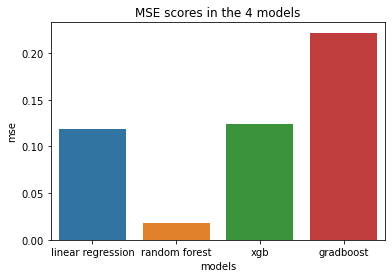

In [14]:
# Models performance
data = {'models':['linear regression', 'random forest', 'xgb', 'gradboost'], 
        'mse':[0.11848353838194997, 0.018030971405377398, 0.12452821718981405,0.2217410065237111 ],
        'mae':[0.25272612891484786, 0.07500417121068341,0.03187673969685498,0.0966456895614806]}
performance = pd.DataFrame(data, columns = ['models', 'mse', 'mae'])
sns.barplot(x = performance.models,  y = performance.mse)
plt.title('MSE scores in the 4 models')

Text(0.5, 1.0, 'MAE scores in the 4 models')

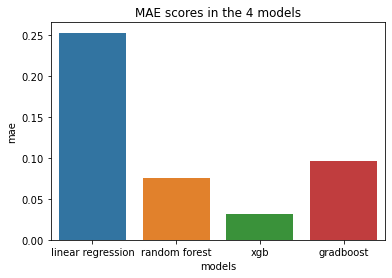

In [15]:
sns.barplot(x = performance.models,  y = performance.mae)
plt.title('MAE scores in the 4 models')

## serializing

In [16]:
models=[rf,gdb,lr,xgb]
with open("../pickles/30-07-2021-20-51-03-00.pkl.", "wb") as f:
    for model in models:
         pickle.dump(model, f)

In [17]:
# make predictions using the random forest model
final_pred = rf.predict(x_test)
final_pred.shape

(41088,)

In [19]:
'''reconstruct a df with StoreID, date and Sales columns using the predcitions and the test set then save it as a csv file'''

sub = test_store[['Id']]
back = np.expm1(final_pred)
sub['Sales'] = back
sub['Date'] = test_store.Date.to_list()
sub['Store'] = test_store.Store.to_list()
sub.to_csv('../data/submission.csv', index = False)

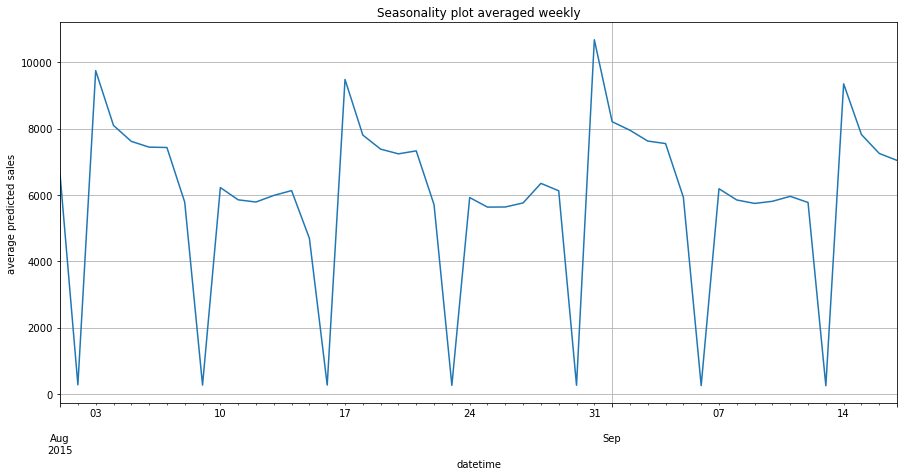

In [20]:
time_data = sub[['Date', 'Sales']]
time_data['datetime'] = pd.to_datetime(time_data['Date'])
time_data = time_data.set_index('datetime')
time_data = time_data.drop(['Date'], axis = 1)
monthly_time_data = time_data.Sales.resample('D').mean() 
plt.figure(figsize = (15,7))
plt.title('Seasonality plot averaged weekly')
plt.ylabel('average predicted sales')
monthly_time_data.plot()
plt.grid()